In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.utils import Sequence
import cv2
import matplotlib.pyplot as plt


img_size = 224

def load_data(IMAGES_PATH, annotations):
    images = []
    gaze_labels = []
    
    
    for index, row in annotations.iterrows():
        
            img_path = os.path.join(IMAGES_PATH, row[0])
            image = cv2.imread(img_path)
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = image / 255.0
            
            image_resized = cv2.resize(image, (img_size, img_size))

            images.append(image_resized)
            
            label = row[1]
            
            if label < -1:
                gaze_labels.append('left')
            elif label > 1:
                gaze_labels.append('right')
            else:
                gaze_labels.append('center')
                
            
    return np.array(images), np.array(gaze_labels)
    
annotations1 = pd.read_csv('/kaggle/input/columbia-face-and-bb-dataset/Columbia DataSet/_annotations.csv')
X, Y = load_data('/kaggle/input/columbia-face-and-bb-dataset/Columbia DataSet', annotations1)

/tmp/ipykernel_30/2864770992.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(IMAGES_PATH, row[0])
/tmp/ipykernel_30/2864770992.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]


In [2]:
import numpy as np


X = np.stack((X,) * 3, axis=-1)

In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_class_flat = label_encoder.fit_transform(Y.flatten())
y_train_class_encoded = to_categorical(y_train_class_flat)

In [5]:
y_train_class_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y_train_class_encoded, test_size=0.3, shuffle=True, random_state=42)

In [7]:
import tensorflow as tf

bbox_model = tf.keras.models.load_model('/kaggle/input/eye-detection-model/tensorflow1/default/1/modelx9.h5')
gaze_model = tf.keras.models.load_model('/kaggle/input/gaze-detection-model-v3/tensorflow2/default/1/model_gaze_3.h5')

In [8]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras import Model
import tensorflow as tf


face_input = Input(shape=(224, 224, 3))
bbox_output = bbox_model(face_input)

def crop_eyes_single(face_img, bbox_coords):
    x1, y1, x2, y2, xx1, yy1, xx2, yy2 = tf.split(bbox_coords, 
                                                  num_or_size_splits=8, axis=-1)
    
    x1, y1, x2, y2 = [tf.squeeze(tf.cast(coord, tf.int32)) for coord in [x1, y1, x2, y2]]
    xx1, yy1, xx2, yy2 = [tf.squeeze(tf.cast(coord, tf.int32)) for coord in [xx1, yy1, xx2, yy2]]
    
    left_eye = face_img[y1:y2, x1:x2, :]
    right_eye = face_img[yy1:yy2, xx1:xx2, :]

    left_eye_resized = tf.image.resize(left_eye, [224, 224])
    right_eye_resized = tf.image.resize(right_eye, [224, 224])

    return tf.stack([left_eye_resized, right_eye_resized], axis=0)

def crop_eyes(face_imgs, bbox_coords):
    return tf.map_fn(
        lambda x: crop_eyes_single(x[0], x[1]),
        (face_imgs, bbox_coords),
        dtype=tf.float32
    )

cropped_eyes = Lambda(
    lambda x: crop_eyes(x[0], x[1]),
    output_shape=(2, 224, 224, 3),
    name="Lambda_Layer"
)([face_input, bbox_output])

left_eyes = cropped_eyes[:, 0, :, :, :]
right_eyes = cropped_eyes[:, 1, :, :, :]

gaze_direction = gaze_model([left_eyes, right_eyes])
combined_model = Model(inputs=face_input, outputs=gaze_direction)

for layer in bbox_model.layers:
    layer.trainable = False

for layer in gaze_model.layers:
    layer.trainable = False
    

combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
combined_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 8)         │ 10,726,664 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Lambda_Layer        │ (None, 2, 224,    │          0 │ input_layer[0][0… │
│ (Lambda)            │ 224, 3)           │            │ functional_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224,  │          0 │ Lambda_Layer[0][… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224,  │          0 │ Lambda_Layer[0][… │
│ (GetItem)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 3)         │ 18,300,291 │ get_item[0][0],   │
│ (Functional)        │                   │            │ get_item_1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,026,955 (110.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 29,026,955 (110.73 MB)

In [12]:
results = combined_model.predict(X_test[0:1000])

30/30 ━━━━━━━━━━━━━━━━━━━━ 498s 17s/step


In [13]:
predicted_labels = np.argmax(results, axis=1)
true_labels = np.argmax(Y_test[0:1000], axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print("Accuracy:", accuracy)

Accuracy: 0.6819603753910324


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
 

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
conf_matrix = confusion_matrix(true_labels, predicted_labels)


print(f"- Accuracy: {accuracy:.2f}")
print(f"- Precision: {precision:.2f}")
print(f"- Recall: {recall:.2f}")
print(f"- F1-Score: {f1:.2f}")

- Accuracy: 0.68
- Precision: 0.75
- Recall: 0.68
- F1-Score: 0.69


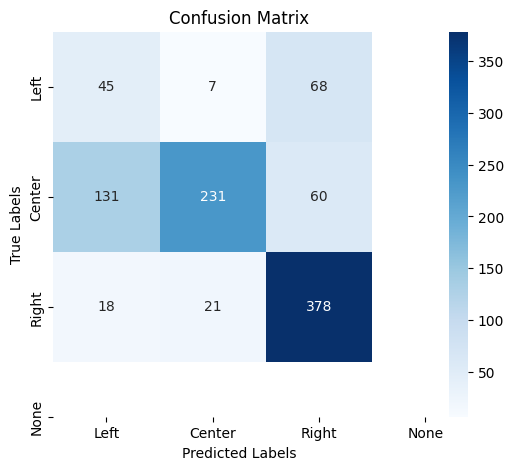

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Left", "Center", "Right", "None"], 
            yticklabels=["Left", "Center", "Right", 'None'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

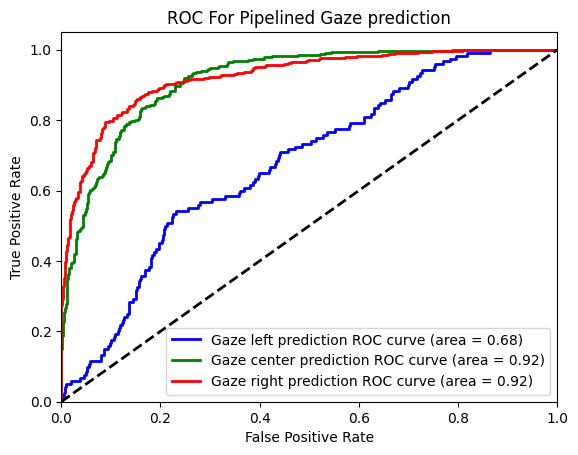

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score


def plot_roc_auc(y_test, y_pred_probs, n_classes):

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    classes = ['left', 'center', 'right']
    for i, color in zip(range(n_classes), colors[:n_classes]):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label=f'Gaze {classes[i]} prediction ROC curve (area = {roc_auc[i]:.2f})'
        )

    plt.plot([0, 1], [0, 1], 'k--', lw=2) 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC For Pipelined Gaze prediction')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_auc(Y_test, results, 3)